## Fine-tune SegFormer on a custom dataset

In this notebook, we are going to fine-tune [SegFormerForSemanticSegmentation](https://huggingface.co/docs/transformers/main/model_doc/segformer#transformers.SegformerForSemanticSegmentation) on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [ ]:
!pip install -q transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 47.5 MB/s eta 0:00:00


## Download toy dataset

Here we download a small subset of the ADE20k dataset, which is an important benchmark for semantic segmentation. It contains 150 labels.

I've made a small subset just for demonstration purposes (namely the 10 first training and 10 first validation images + segmentation maps). The goal for the model is to overfit this tiny dataset (because that makes sure that it'll work on a larger scale).

In [ ]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/l1e45oht447053f/ADE20k_toy_dataset.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

Note that this dataset is now also available on the hub :) you can directly check out the images [in your browser](scene_parse_150)! It can be easily loaded as follows (note that loading will take some time as the dataset is several GB's large):

In [ ]:
from datasets import load_dataset

load_entire_dataset = False

if load_entire_dataset:
  dataset = load_dataset("scene_parse_150")

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image

class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            image_processor (SegFormerImageProcessor): image processor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.image_processor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the image processor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [ ]:
from transformers import SegformerImageProcessor

root_dir = '/content/ADE20k_toy_dataset'
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, image_processor=image_processor, train=False)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 10
Number of validation examples: 10


Let's verify a random example:

In [ ]:
encoded_inputs = train_dataset[0]

In [ ]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [ ]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [ ]:
encoded_inputs["labels"]

tensor([[255, 255, 255,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        [255,   5,   5,  ...,   5,   5,   5],
        ...,
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0, 255],
        [  3,   3,   3,  ...,   0,   0,   0]])

In [ ]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0,   3,   4,   5,  12,  17,  31,  32,  42,  43,  87,  96, 104, 125,
        138, 149, 255])

Next, we define corresponding dataloaders.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [ ]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [ ]:
mask = (batch["labels"] != 255)
mask

tensor([[[ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         [ True,  True,  True,  ...,  True,  True, False],
         ...,
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True,  True,  True]],

        [[False, False, False,  ..., False, False, False],
         [False,  True,  True,  ...,  True, False, False],
         [False,  True,  True,  ...,  True, False, False],
         ...,
         [False,  True,  True,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True, False],
         [False, False, False,  ..., False, False, False]]])

In [ ]:
batch["labels"][mask]

tensor([5, 5, 5,  ..., 3, 3, 3])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [ ]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import hf_hub_download

# load id2label mapping from a JSON on the hub
repo_id = "huggingface/label-files"
filename = "ade20k-id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [ ]:
import evaluate

metric = evaluate.load("mean_iou")

In [ ]:
image_processor.do_reduce_labels

True

In [ ]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          # currently using _compute instead of compute
          # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
          metrics = metric._compute(
                  predictions=predicted.cpu(),
                  references=labels.cpu(),
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

Epoch: 0


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 4.996979713439941
Mean_iou: 0.00013692387034232496
Mean accuracy: 0.002205290838433202
Epoch: 1


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.882101058959961
Mean_iou: 0.001999506164092187
Mean accuracy: 0.020852088862279097
Epoch: 2


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.61370849609375
Mean_iou: 0.017014122779019987
Mean accuracy: 0.17937738488421207
Epoch: 3


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.621042728424072
Mean_iou: 0.019609546702719294
Mean accuracy: 0.14623513688982673
Epoch: 4


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.4428324699401855
Mean_iou: 0.037321412377421107
Mean accuracy: 0.32948944072639674
Epoch: 5


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.362587928771973
Mean_iou: 0.03297380786930174
Mean accuracy: 0.3640272633849943
Epoch: 6


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.261390686035156
Mean_iou: 0.04020141017882981
Mean accuracy: 0.2533318682472344
Epoch: 7


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.777461051940918
Mean_iou: 0.09584854674054956
Mean accuracy: 0.5173927069257795
Epoch: 8


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 4.009483337402344
Mean_iou: 0.07185385002613716
Mean accuracy: 0.4331936266541808
Epoch: 9


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.79325270652771
Mean_iou: 0.09367652681756139
Mean accuracy: 0.31642252311470176
Epoch: 10


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.2135701179504395
Mean_iou: 0.2629201283395063
Mean accuracy: 0.7650981334441594
Epoch: 11


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.317331075668335
Mean_iou: 0.10095353505704684
Mean accuracy: 0.2135962625194837
Epoch: 12


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.893195867538452
Mean_iou: 0.13985622374947274
Mean accuracy: 0.2541087986356554
Epoch: 13


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 3.307095527648926
Mean_iou: 0.1333262315863549
Mean accuracy: 0.2422305866548488
Epoch: 14


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.5652666091918945
Mean_iou: 0.17813530333099925
Mean accuracy: 0.2702353646814486
Epoch: 15


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.9123501777648926
Mean_iou: 0.13378846470823333
Mean accuracy: 0.27601260071145517
Epoch: 16


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.924081325531006
Mean_iou: 0.37299590750187983
Mean accuracy: 0.544542048038698
Epoch: 17


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.9672837257385254
Mean_iou: 0.20563261469869637
Mean accuracy: 0.43998702535664963
Epoch: 18


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.208246946334839
Mean_iou: 0.19762480930974372
Mean accuracy: 0.27289090488784884
Epoch: 19


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.7604639530181885
Mean_iou: 0.11556098875018106
Mean accuracy: 0.2176389384685907
Epoch: 20


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.458246946334839
Mean_iou: 0.273316806438651
Mean accuracy: 0.3929694238821305
Epoch: 21


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.3313686847686768
Mean_iou: 0.38281943545758157
Mean accuracy: 0.5016423216890389
Epoch: 22


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6050820350646973
Mean_iou: 0.30977255500959344
Mean accuracy: 0.47656548464935683
Epoch: 23


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1199042797088623
Mean_iou: 0.2637181140352751
Mean accuracy: 0.5372897827827451
Epoch: 24


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.6292474269866943
Mean_iou: 0.3390739496096081
Mean accuracy: 0.5138400654411547
Epoch: 25


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9379205703735352
Mean_iou: 0.25933208364189475
Mean accuracy: 0.42442820364500755
Epoch: 26


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0349650382995605
Mean_iou: 0.0943234941267751
Mean accuracy: 0.15783629814597055
Epoch: 27


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.19429349899292
Mean_iou: 0.2289899229565505
Mean accuracy: 0.3749391705088774
Epoch: 28


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0277252197265625
Mean_iou: 0.1541268036969431
Mean accuracy: 0.25050892760457444
Epoch: 29


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9236876964569092
Mean_iou: 0.3941535433460017
Mean accuracy: 0.5125343445980521
Epoch: 30


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.0909423828125
Mean_iou: 0.3997106123957052
Mean accuracy: 0.5627630112886716
Epoch: 31


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5012006759643555
Mean_iou: 0.5773848530876382
Mean accuracy: 0.8471204897347362
Epoch: 32


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6027694940567017
Mean_iou: 0.37438410025045826
Mean accuracy: 0.4647621306907836
Epoch: 33


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7763307094573975
Mean_iou: 0.1661466916925296
Mean accuracy: 0.303462703805095
Epoch: 34


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.1090095043182373
Mean_iou: 0.36999193943327335
Mean accuracy: 0.4506167616981691
Epoch: 35


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9792085886001587
Mean_iou: 0.23199952426949857
Mean accuracy: 0.3195623688583974
Epoch: 36


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 2.069234848022461
Mean_iou: 0.3090624142385803
Mean accuracy: 0.5129623278036706
Epoch: 37


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.9950886964797974
Mean_iou: 0.3666175487493472
Mean accuracy: 0.5182141304213046
Epoch: 38


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7286059856414795
Mean_iou: 0.5250379357367391
Mean accuracy: 0.715733239084654
Epoch: 39


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1822547912597656
Mean_iou: 0.4888973773651129
Mean accuracy: 0.7018712408181731
Epoch: 40


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.8943357467651367
Mean_iou: 0.3726406554404659
Mean accuracy: 0.5553874927393126
Epoch: 41


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6909159421920776
Mean_iou: 0.28154815015569185
Mean accuracy: 0.4106033028562512
Epoch: 42


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.7941921949386597
Mean_iou: 0.19860106941253974
Mean accuracy: 0.31151706348526637
Epoch: 43


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.171984076499939
Mean_iou: 0.41780538698529257
Mean accuracy: 0.5124802109398228
Epoch: 44


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4883320331573486
Mean_iou: 0.40272462511796564
Mean accuracy: 0.7329785905329945
Epoch: 45


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1822177171707153
Mean_iou: 0.42020093594448266
Mean accuracy: 0.5144294479724684
Epoch: 46


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.515447735786438
Mean_iou: 0.22739950661524433
Mean accuracy: 0.3088602799236268
Epoch: 47


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.6938073635101318
Mean_iou: 0.3790165847035018
Mean accuracy: 0.5260127796150817
Epoch: 48


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3731440305709839
Mean_iou: 0.1852789982512921
Mean accuracy: 0.2540702791846177
Epoch: 49


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5390936136245728
Mean_iou: 0.21385814303160405
Mean accuracy: 0.32278099422382056
Epoch: 50


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8603699803352356
Mean_iou: 0.6731465967873377
Mean accuracy: 0.7965515327483375
Epoch: 51


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3131510019302368
Mean_iou: 0.19159583633782803
Mean accuracy: 0.2581815279531604
Epoch: 52


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5800801515579224
Mean_iou: 0.2366740726473181
Mean accuracy: 0.3123605074059236
Epoch: 53


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.252747654914856
Mean_iou: 0.1876534507940824
Mean accuracy: 0.3096483185340702
Epoch: 54


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0922892093658447
Mean_iou: 0.17597075131575182
Mean accuracy: 0.27596789597592647
Epoch: 55


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2182495594024658
Mean_iou: 0.3569002295696239
Mean accuracy: 0.5229402942016734
Epoch: 56


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.06999671459198
Mean_iou: 0.3642840973796327
Mean accuracy: 0.5843708534938759
Epoch: 57


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3528703451156616
Mean_iou: 0.44850900285759876
Mean accuracy: 0.5902484271067417
Epoch: 58


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7319279909133911
Mean_iou: 0.6282628220100144
Mean accuracy: 0.8023908974042167
Epoch: 59


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.4682530164718628
Mean_iou: 0.12391388811076766
Mean accuracy: 0.21362075723289148
Epoch: 60


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.5021480321884155
Mean_iou: 0.23965985981390728
Mean accuracy: 0.3193069444643441
Epoch: 61


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.434057593345642
Mean_iou: 0.38111617251120256
Mean accuracy: 0.4588291799684869
Epoch: 62


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6740013957023621
Mean_iou: 0.37147568654703117
Mean accuracy: 0.5226391247907014
Epoch: 63


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9257558584213257
Mean_iou: 0.6196833704646028
Mean accuracy: 0.7247303777489741
Epoch: 64


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7951446771621704
Mean_iou: 0.5103056666549477
Mean accuracy: 0.7173170591732352
Epoch: 65


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.281815767288208
Mean_iou: 0.435219501578401
Mean accuracy: 0.5149208136513076
Epoch: 66


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.39746198058128357
Mean_iou: 0.3708804412483043
Mean accuracy: 0.6173811311642302
Epoch: 67


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0534008741378784
Mean_iou: 0.43819871951292516
Mean accuracy: 0.5475714856618068
Epoch: 68


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7821269035339355
Mean_iou: 0.3307394576965033
Mean accuracy: 0.627538133960356
Epoch: 69


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.3291736841201782
Mean_iou: 0.23692470321986644
Mean accuracy: 0.31526669096651155
Epoch: 70


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0196235179901123
Mean_iou: 0.6407326964487035
Mean accuracy: 0.8222827962450625
Epoch: 71


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9847832322120667
Mean_iou: 0.2298970327284752
Mean accuracy: 0.3530839091681342
Epoch: 72


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8237496614456177
Mean_iou: 0.33103750789324365
Mean accuracy: 0.6211712433278894
Epoch: 73


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.2011994123458862
Mean_iou: 0.209431325053351
Mean accuracy: 0.30973638322287994
Epoch: 74


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.926453709602356
Mean_iou: 0.23350607678038723
Mean accuracy: 0.35473559481754263
Epoch: 75


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5035046935081482
Mean_iou: 0.44222398225373655
Mean accuracy: 0.5210732015215386
Epoch: 76


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8394492864608765
Mean_iou: 0.29201851108597704
Mean accuracy: 0.43855129817377614
Epoch: 77


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.0453829765319824
Mean_iou: 0.44575905281988315
Mean accuracy: 0.5647335902912299
Epoch: 78


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9539852142333984
Mean_iou: 0.4959064372181584
Mean accuracy: 0.5756462105788086
Epoch: 79


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.1354869604110718
Mean_iou: 0.3709845921775615
Mean accuracy: 0.4827019761419115
Epoch: 80


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9722335934638977
Mean_iou: 0.35157461272802837
Mean accuracy: 0.4593658679668052
Epoch: 81


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.42178285121917725
Mean_iou: 0.6003622806716261
Mean accuracy: 0.855590718417827
Epoch: 82


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7665726542472839
Mean_iou: 0.22636233793884766
Mean accuracy: 0.3180257019392759
Epoch: 83


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8933832049369812
Mean_iou: 0.3918294922788353
Mean accuracy: 0.4914350953483435
Epoch: 84


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.745746910572052
Mean_iou: 0.5869163616968672
Mean accuracy: 0.7935845948322698
Epoch: 85


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9003615975379944
Mean_iou: 0.7054608080873859
Mean accuracy: 0.8202180543738216
Epoch: 86


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9933323860168457
Mean_iou: 0.4182534958576708
Mean accuracy: 0.7370767793090652
Epoch: 87


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8200610876083374
Mean_iou: 0.25041543630375906
Mean accuracy: 0.34922867887870723
Epoch: 88


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8487763404846191
Mean_iou: 0.48754246929680156
Mean accuracy: 0.5896947903103436
Epoch: 89


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9366667866706848
Mean_iou: 0.19224668799944178
Mean accuracy: 0.2676228456728222
Epoch: 90


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2941533029079437
Mean_iou: 0.730868109259554
Mean accuracy: 0.845535634208072
Epoch: 91


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6496132016181946
Mean_iou: 0.406278047566228
Mean accuracy: 0.528871306060065
Epoch: 92


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4927705228328705
Mean_iou: 0.41019311771874123
Mean accuracy: 0.5202160835510871
Epoch: 93


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 1.013367772102356
Mean_iou: 0.20580702178374977
Mean accuracy: 0.29718474765856
Epoch: 94


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8018313646316528
Mean_iou: 0.12622191160598945
Mean accuracy: 0.2154280366961014
Epoch: 95


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5226513147354126
Mean_iou: 0.5603960646962316
Mean accuracy: 0.6248213069954628
Epoch: 96


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7161865234375
Mean_iou: 0.6362395128674425
Mean accuracy: 0.8427069011410663
Epoch: 97


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8638309240341187
Mean_iou: 0.4835326119178291
Mean accuracy: 0.6141212663976396
Epoch: 98


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9343953132629395
Mean_iou: 0.5148031846556147
Mean accuracy: 0.6370522813391243
Epoch: 99


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8260239362716675
Mean_iou: 0.2679920713110272
Mean accuracy: 0.3718209296853827
Epoch: 100


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.880521833896637
Mean_iou: 0.4956248181158031
Mean accuracy: 0.6325024699262128
Epoch: 101


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5153728127479553
Mean_iou: 0.5644603030178514
Mean accuracy: 0.7362584103407621
Epoch: 102


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7422638535499573
Mean_iou: 0.4281079131746522
Mean accuracy: 0.5435189457911092
Epoch: 103


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8208547830581665
Mean_iou: 0.4057806041138909
Mean accuracy: 0.46799797936979787
Epoch: 104


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.8012393712997437
Mean_iou: 0.22458205609714738
Mean accuracy: 0.29448616253901944
Epoch: 105


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4801788330078125
Mean_iou: 0.6245417776401326
Mean accuracy: 0.7345932566147003
Epoch: 106


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.35133495926856995
Mean_iou: 0.48531943919196735
Mean accuracy: 0.5988103936450497
Epoch: 107


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.797814667224884
Mean_iou: 0.29491185433457134
Mean accuracy: 0.3730370815568144
Epoch: 108


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4523709714412689
Mean_iou: 0.5775742620608285
Mean accuracy: 0.643760545103894
Epoch: 109


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7388825416564941
Mean_iou: 0.5777974566685644
Mean accuracy: 0.6474587924305519
Epoch: 110


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2954377233982086
Mean_iou: 0.510625605335497
Mean accuracy: 0.8608391820340054
Epoch: 111


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.811658501625061
Mean_iou: 0.19212675452899813
Mean accuracy: 0.2830635186621595
Epoch: 112


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6563704609870911
Mean_iou: 0.553689736607589
Mean accuracy: 0.6431689426066381
Epoch: 113


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6056990623474121
Mean_iou: 0.1704854469296811
Mean accuracy: 0.2622425487381377
Epoch: 114


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7939677238464355
Mean_iou: 0.4089099267964109
Mean accuracy: 0.5604908126441525
Epoch: 115


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5894441604614258
Mean_iou: 0.5662842050945326
Mean accuracy: 0.6826588636635808
Epoch: 116


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6551770567893982
Mean_iou: 0.41089701541681134
Mean accuracy: 0.5583847890888115
Epoch: 117


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4512144923210144
Mean_iou: 0.4425543378027741
Mean accuracy: 0.5818848977492325
Epoch: 118


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6267340183258057
Mean_iou: 0.4170615321544387
Mean accuracy: 0.49133063395816556
Epoch: 119


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6192644238471985
Mean_iou: 0.27110156278174746
Mean accuracy: 0.32499590074492185
Epoch: 120


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6786611080169678
Mean_iou: 0.5927589526211362
Mean accuracy: 0.6719211807206426
Epoch: 121


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.38549500703811646
Mean_iou: 0.5664195278618578
Mean accuracy: 0.6744256346677766
Epoch: 122


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6115758419036865
Mean_iou: 0.6245132504505191
Mean accuracy: 0.708825289942517
Epoch: 123


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3850671947002411
Mean_iou: 0.5653660666759489
Mean accuracy: 0.6747207351067543
Epoch: 124


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4737861752510071
Mean_iou: 0.4478720662951941
Mean accuracy: 0.5460243307065341
Epoch: 125


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5440977811813354
Mean_iou: 0.26777453453880096
Mean accuracy: 0.3848308400111063
Epoch: 126


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3327338695526123
Mean_iou: 0.5062044197173502
Mean accuracy: 0.740481104708941
Epoch: 127


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6956413984298706
Mean_iou: 0.4088088812124477
Mean accuracy: 0.5747854321118037
Epoch: 128


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.38378047943115234
Mean_iou: 0.6346127553308373
Mean accuracy: 0.7434979174045622
Epoch: 129


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21298424899578094
Mean_iou: 0.6500964024499889
Mean accuracy: 0.9196635313942337
Epoch: 130


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.16232000291347504
Mean_iou: 0.8361836699890868
Mean accuracy: 0.8553746941735113
Epoch: 131


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.6283109784126282
Mean_iou: 0.41202334637465504
Mean accuracy: 0.5692820744762929
Epoch: 132


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.7207377552986145
Mean_iou: 0.3867990076211461
Mean accuracy: 0.4701744443681084
Epoch: 133


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4874417185783386
Mean_iou: 0.2017200978844053
Mean accuracy: 0.31716988253712936
Epoch: 134


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3362507224082947
Mean_iou: 0.4993052225228774
Mean accuracy: 0.6021804021431594
Epoch: 135


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.9401882290840149
Mean_iou: 0.20248232915927925
Mean accuracy: 0.2931213355995761
Epoch: 136


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5225436091423035
Mean_iou: 0.2596796679543638
Mean accuracy: 0.4621796201038614
Epoch: 137


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.538654625415802
Mean_iou: 0.4120454358683114
Mean accuracy: 0.5283060684935679
Epoch: 138


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4894615411758423
Mean_iou: 0.6733019954404736
Mean accuracy: 0.7675935231442108
Epoch: 139


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5967005491256714
Mean_iou: 0.608053466971939
Mean accuracy: 0.6762755112003046
Epoch: 140


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3086331784725189
Mean_iou: 0.5893076890070805
Mean accuracy: 0.6943224511065232
Epoch: 141


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.42274904251098633
Mean_iou: 0.6391829770097033
Mean accuracy: 0.7164167024003046
Epoch: 142


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.30333006381988525
Mean_iou: 0.43647210966915406
Mean accuracy: 0.697472618023532
Epoch: 143


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4906471371650696
Mean_iou: 0.6473992597119869
Mean accuracy: 0.729964088276406
Epoch: 144


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.45499056577682495
Mean_iou: 0.4765842521169988
Mean accuracy: 0.5196096143480091
Epoch: 145


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4590955972671509
Mean_iou: 0.6707644483940381
Mean accuracy: 0.6966699058534778
Epoch: 146


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5362212061882019
Mean_iou: 0.5836350953617225
Mean accuracy: 0.6682989853320113
Epoch: 147


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4280420243740082
Mean_iou: 0.4074546628324417
Mean accuracy: 0.5597696390080759
Epoch: 148


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.20646925270557404
Mean_iou: 0.825202880085279
Mean accuracy: 0.8501104563314758
Epoch: 149


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3381732404232025
Mean_iou: 0.8130442177962476
Mean accuracy: 0.9384522362367554
Epoch: 150


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2018345296382904
Mean_iou: 0.9273906067925256
Mean accuracy: 0.9591030499829365
Epoch: 151


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3873027265071869
Mean_iou: 0.5306523720937424
Mean accuracy: 0.575843321248358
Epoch: 152


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11710814386606216
Mean_iou: 0.8479298811170302
Mean accuracy: 0.8606325617478067
Epoch: 153


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5554330945014954
Mean_iou: 0.5188842599112781
Mean accuracy: 0.5597516464889908
Epoch: 154


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.38716450333595276
Mean_iou: 0.6344726116173766
Mean accuracy: 0.7143991908618724
Epoch: 155


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3188723921775818
Mean_iou: 0.4194676534769463
Mean accuracy: 0.6037703502162779
Epoch: 156


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11537995934486389
Mean_iou: 0.8441341881497731
Mean accuracy: 0.8598329599675031
Epoch: 157


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.22132377326488495
Mean_iou: 0.4381906322264515
Mean accuracy: 0.7672696040810594
Epoch: 158


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3356456160545349
Mean_iou: 0.41608854764215303
Mean accuracy: 0.5362894051296073
Epoch: 159


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3563297390937805
Mean_iou: 0.6868263944233449
Mean accuracy: 0.721279598672579
Epoch: 160


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3457634747028351
Mean_iou: 0.4879286613962499
Mean accuracy: 0.5828304311042046
Epoch: 161


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4651584327220917
Mean_iou: 0.4945483599926016
Mean accuracy: 0.5669999255667288
Epoch: 162


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.2735951542854309
Mean_iou: 0.6622248920004435
Mean accuracy: 0.6997319974541832
Epoch: 163


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4015357792377472
Mean_iou: 0.21142394615913965
Mean accuracy: 0.31404022789088004
Epoch: 164


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5986664295196533
Mean_iou: 0.42847364179913905
Mean accuracy: 0.4996565810610057
Epoch: 165


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.19267551600933075
Mean_iou: 0.577341772195839
Mean accuracy: 0.6301537907935569
Epoch: 166


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4630924165248871
Mean_iou: 0.5355462650347717
Mean accuracy: 0.5781234931653478
Epoch: 167


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36798393726348877
Mean_iou: 0.7981560361016912
Mean accuracy: 0.8218803812222654
Epoch: 168


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.13836780190467834
Mean_iou: 0.9391245194435687
Mean accuracy: 0.9547870846101192
Epoch: 169


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4883396029472351
Mean_iou: 0.5973841695124068
Mean accuracy: 0.665088918839894
Epoch: 170


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.27174538373947144
Mean_iou: 0.7531557339219225
Mean accuracy: 0.8730263722251281
Epoch: 171


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.5013584494590759
Mean_iou: 0.3738588454114178
Mean accuracy: 0.44539195682194577
Epoch: 172


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3975052833557129
Mean_iou: 0.5727780169598944
Mean accuracy: 0.6836127276124285
Epoch: 173


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3435210883617401
Mean_iou: 0.5555318867087947
Mean accuracy: 0.5912077953488336
Epoch: 174


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.11715171486139297
Mean_iou: 0.9597936029669656
Mean accuracy: 0.9772432904064191
Epoch: 175


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.25897854566574097
Mean_iou: 0.8493670558672505
Mean accuracy: 0.8838535102534343
Epoch: 176


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.17897199094295502
Mean_iou: 0.47253530957145606
Mean accuracy: 0.7467376170698378
Epoch: 177


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.45955348014831543
Mean_iou: 0.5693615919489377
Mean accuracy: 0.6434558424366549
Loss: 0.6329169273376465
Mean_iou: 0.3403587156711907
Mean accuracy: 0.4112498064539456
Epoch: 179


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.29677534103393555
Mean_iou: 0.8324168579825912
Mean accuracy: 0.8820730979072845
Epoch: 180


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.36615267395973206
Mean_iou: 0.4251531300723964
Mean accuracy: 0.4819842829930952
Epoch: 181


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3125467002391815
Mean_iou: 0.7028054323788018
Mean accuracy: 0.742674557292987
Epoch: 182


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.19419001042842865
Mean_iou: 0.438962832981267
Mean accuracy: 0.7733844303876323
Epoch: 183


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.24052952229976654
Mean_iou: 0.9330626634180361
Mean accuracy: 0.9541695709796277
Epoch: 184


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.49403661489486694
Mean_iou: 0.4531368323762737
Mean accuracy: 0.5914512870137968
Epoch: 185


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.12709097564220428
Mean_iou: 0.9393630134007062
Mean accuracy: 0.9587030676212587
Epoch: 186


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.18972884118556976
Mean_iou: 0.4418121437750285
Mean accuracy: 0.7790832189150223
Epoch: 187


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3218836486339569
Mean_iou: 0.6929575035814266
Mean accuracy: 0.7188660330380601
Epoch: 188


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.46244633197784424
Mean_iou: 0.5953017741514812
Mean accuracy: 0.6299076691857911
Epoch: 189


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.3426051139831543
Mean_iou: 0.4102153979800669
Mean accuracy: 0.4839003668430867
Epoch: 190


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.21856549382209778
Mean_iou: 0.8563154125766741
Mean accuracy: 0.8806729318444803
Epoch: 191


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.38950175046920776
Mean_iou: 0.5439105201667005
Mean accuracy: 0.6573229436068695
Epoch: 192


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4280233085155487
Mean_iou: 0.5681356739980721
Mean accuracy: 0.6149372831083311
Epoch: 193


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.31598976254463196
Mean_iou: 0.29037103722667984
Mean accuracy: 0.5475626135055776
Epoch: 194


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.465514212846756
Mean_iou: 0.5412055750461681
Mean accuracy: 0.5798339575742749
Epoch: 195


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.336211234331131
Mean_iou: 0.3653418921251268
Mean accuracy: 0.4540494978425859
Epoch: 196


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.1720103919506073
Mean_iou: 0.507270604729829
Mean accuracy: 0.6305694517151459
Epoch: 197


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.27938103675842285
Mean_iou: 0.8444219250451692
Mean accuracy: 0.868460197232099
Epoch: 198


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.4050583839416504
Mean_iou: 0.40524954531335006
Mean accuracy: 0.47588892904996527
Epoch: 199


  0%|          | 0/5 [00:00<?, ?it/s]

Loss: 0.34554606676101685
Mean_iou: 0.6258326079660507
Mean accuracy: 0.6838870916595304


## Inference

Finally, let's check whether the model has really learned something.

Let's test the trained model on an image (refer to my [inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Segformer_inference_notebook.ipynb) for details):

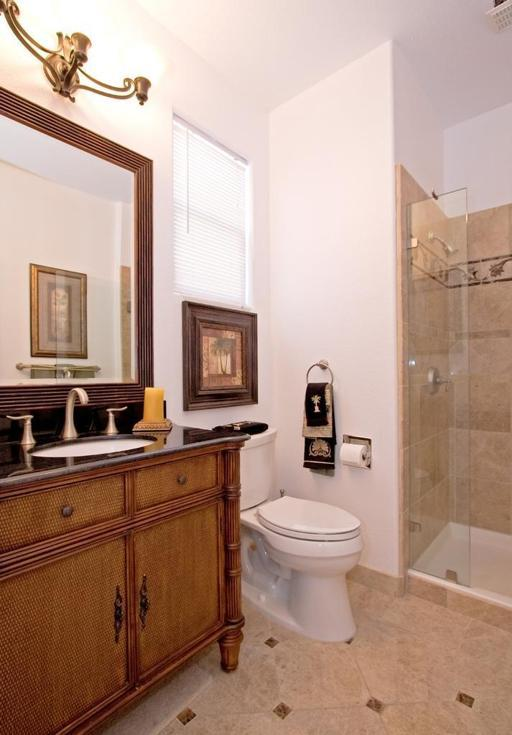

In [ ]:
image = Image.open('/content/ADE20k_toy_dataset/images/training/ADE_train_00000007.jpg')
image

In [ ]:
# prepare the image for the model
pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [ ]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(pixel_values=pixel_values)

In [ ]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 150, 128, 128])


In [ ]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [ ]:
predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
print(predicted_segmentation_map)

[[ 0  0  0 ...  5  5  5]
 [ 0  0  0 ...  5  5  5]
 [ 0  0  0 ...  5  5  5]
 ...
 [10 10 10 ...  3  3  3]
 [10 10 10 ...  3  3  3]
 [10 10 10 ...  3  3  3]]


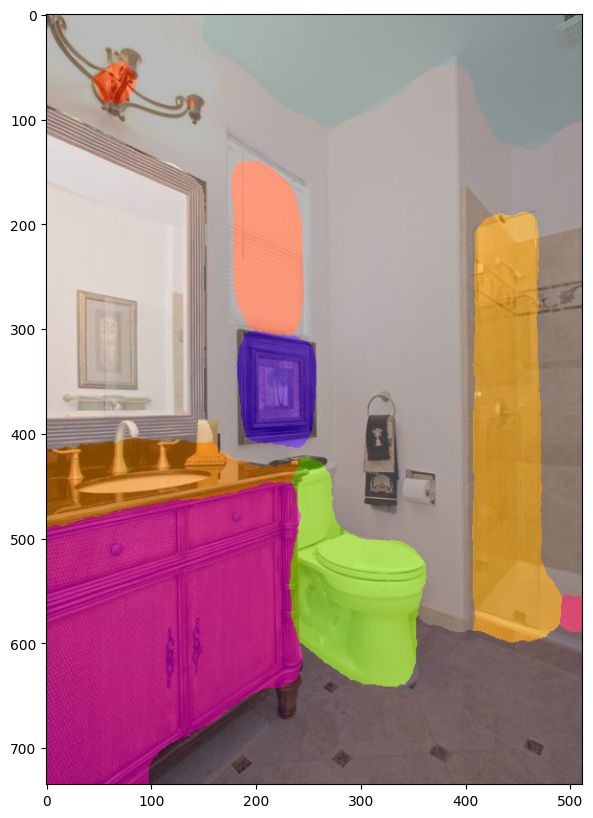

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((predicted_segmentation_map.shape[0],
                      predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[predicted_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

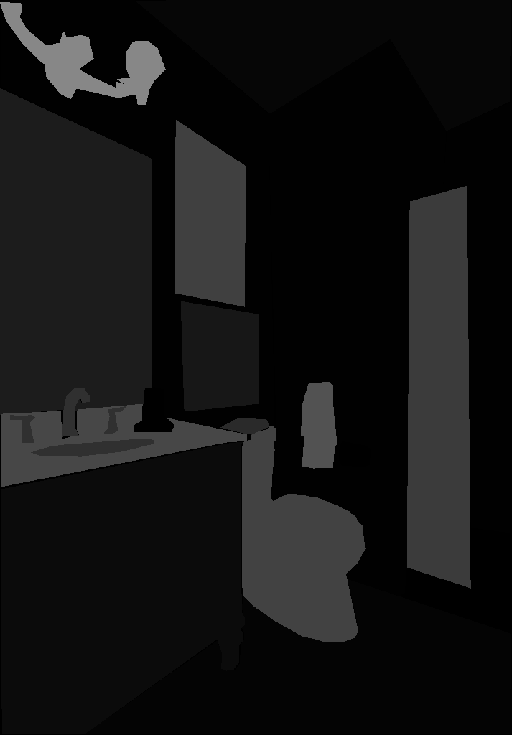

In [ ]:
map = Image.open('/content/ADE20k_toy_dataset/annotations/training/ADE_train_00000007.png')
map

Classes in this image: ['wall', 'floor', 'ceiling', 'cabinet', 'painting', 'mirror', 'box', 'sink', 'screen door', 'blind', 'toilet', 'countertop', 'towel', 'sconce', None]


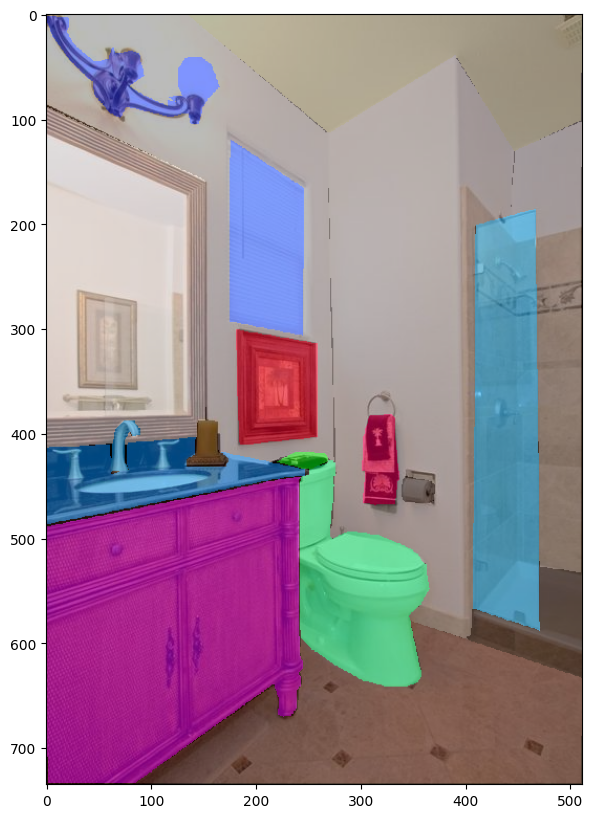

In [ ]:
# convert map to NumPy array
import cv2
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
map[map == 254] = 255

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = cv2.resize(color_seg, (img.shape[1], img.shape[0]))

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Let's compute the metrics:

In [ ]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[predicted_segmentation_map],
                  references=[map],
                  num_labels=len(id2label),
                  ignore_index=255,
                  reduce_labels=False, # we've already reduced the labels ourselves
              )

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


In [ ]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [ ]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.6615131912519485
mean_accuracy 0.7025854752678986
overall_accuracy 0.9431708848094777
---------------------
per-category metrics:


IoU  accuracy
wall      0.886532  0.968313
building       NaN       NaN
sky            NaN       NaN
floor     0.945023  0.989379
tree           NaN       NaN
...            ...       ...
shower         NaN       NaN
radiator       NaN       NaN
glass          NaN       NaN
clock          NaN       NaN
flag           NaN       NaN

[150 rows x 2 columns]

In [ ]:
metric_table

{'wall': [0.8865320467463397, 0.96831341775162],
 'building': [nan, nan],
 'sky': [nan, nan],
 'floor': [0.9450228266383246, 0.9893786510886883],
 'tree': [nan, nan],
 'ceiling': [0.9335859076484684, 0.9900415507709214],
 'road': [nan, nan],
 'bed ': [nan, nan],
 'windowpane': [nan, nan],
 'grass': [nan, nan],
 'cabinet': [0.9548338208860536, 0.9562493381807914],
 'sidewalk': [nan, nan],
 'person': [nan, nan],
 'earth': [nan, nan],
 'door': [nan, nan],
 'table': [nan, nan],
 'mountain': [nan, nan],
 'plant': [nan, nan],
 'curtain': [nan, nan],
 'chair': [nan, nan],
 'car': [nan, nan],
 'water': [nan, nan],
 'painting': [0.8755343223535328, 0.9100888656560376],
 'sofa': [nan, nan],
 'shelf': [nan, nan],
 'house': [nan, nan],
 'sea': [nan, nan],
 'mirror': [0.9792323809085258, 0.9905904273902411],
 'rug': [nan, nan],
 'field': [nan, nan],
 'armchair': [nan, nan],
 'seat': [nan, nan],
 'fence': [nan, nan],
 'desk': [nan, nan],
 'rock': [nan, nan],
 'wardrobe': [nan, nan],
 'lamp': [nan, n